In [1]:
import rasterio
import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

from unet_models import unet11

from test_unet_helpers import calcXYfromRC, checkWindow, gtDatasetSampler2, DigitalGlobeSamplerTensor

from utils import variable
from scipy import misc

from gbdxtools import Interface, CatalogImage




/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expe

In [2]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop

with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [3]:
# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

In [9]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 2000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            #pr_start = ran_row*pan_factorR - side/2
            #pr_end = ran_row*pan_factorR + side/2
            #pc_start = ran_col*pan_factorC - side/2
            #pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            #coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

generating sample 1 of 2000
generating sample 2 of 2000
generating sample 3 of 2000
generating sample 4 of 2000
generating sample 5 of 2000
generating sample 6 of 2000
generating sample 7 of 2000
generating sample 8 of 2000
generating sample 9 of 2000
generating sample 10 of 2000
generating sample 11 of 2000
generating sample 12 of 2000
generating sample 13 of 2000


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


generating sample 14 of 2000
generating sample 15 of 2000
generating sample 16 of 2000
generating sample 17 of 2000
generating sample 18 of 2000
generating sample 19 of 2000
generating sample 20 of 2000
generating sample 21 of 2000
generating sample 22 of 2000
generating sample 23 of 2000
generating sample 24 of 2000
generating sample 25 of 2000
generating sample 26 of 2000
generating sample 27 of 2000
generating sample 28 of 2000
generating sample 29 of 2000
generating sample 30 of 2000
generating sample 31 of 2000
generating sample 32 of 2000
generating sample 33 of 2000
generating sample 34 of 2000
generating sample 35 of 2000
generating sample 36 of 2000
generating sample 37 of 2000
generating sample 38 of 2000
generating sample 39 of 2000
generating sample 40 of 2000
generating sample 41 of 2000
generating sample 42 of 2000
generating sample 43 of 2000
generating sample 44 of 2000
generating sample 45 of 2000
generating sample 46 of 2000
generating sample 47 of 2000
generating sam

generating sample 311 of 2000
generating sample 312 of 2000
generating sample 313 of 2000
generating sample 314 of 2000
generating sample 315 of 2000
generating sample 316 of 2000
generating sample 317 of 2000
generating sample 318 of 2000
generating sample 319 of 2000
generating sample 320 of 2000
generating sample 321 of 2000
generating sample 322 of 2000
generating sample 323 of 2000
generating sample 324 of 2000
generating sample 325 of 2000
generating sample 326 of 2000
generating sample 327 of 2000
generating sample 328 of 2000
generating sample 329 of 2000
generating sample 330 of 2000
generating sample 331 of 2000
generating sample 332 of 2000
generating sample 333 of 2000
generating sample 334 of 2000
generating sample 335 of 2000
generating sample 336 of 2000
generating sample 337 of 2000
generating sample 338 of 2000
generating sample 339 of 2000
generating sample 340 of 2000
generating sample 341 of 2000
generating sample 342 of 2000
generating sample 343 of 2000
generating

generating sample 606 of 2000
generating sample 607 of 2000
generating sample 608 of 2000
generating sample 609 of 2000
generating sample 610 of 2000
generating sample 611 of 2000
generating sample 612 of 2000
generating sample 613 of 2000
generating sample 614 of 2000
generating sample 615 of 2000
generating sample 616 of 2000
generating sample 617 of 2000
generating sample 618 of 2000
generating sample 619 of 2000
generating sample 620 of 2000
generating sample 621 of 2000
generating sample 622 of 2000
generating sample 623 of 2000
generating sample 624 of 2000
generating sample 625 of 2000
generating sample 626 of 2000
generating sample 627 of 2000
generating sample 628 of 2000
generating sample 629 of 2000
generating sample 630 of 2000
generating sample 631 of 2000
generating sample 632 of 2000
generating sample 633 of 2000
generating sample 634 of 2000
generating sample 635 of 2000
generating sample 636 of 2000
generating sample 637 of 2000
generating sample 638 of 2000
generating

generating sample 889 of 2000
generating sample 890 of 2000
generating sample 891 of 2000
generating sample 892 of 2000
generating sample 893 of 2000
generating sample 894 of 2000
generating sample 895 of 2000
generating sample 896 of 2000
generating sample 897 of 2000
generating sample 898 of 2000
generating sample 899 of 2000
generating sample 900 of 2000
generating sample 901 of 2000
generating sample 902 of 2000
generating sample 903 of 2000
generating sample 904 of 2000
generating sample 905 of 2000
generating sample 906 of 2000
generating sample 907 of 2000
generating sample 908 of 2000
generating sample 909 of 2000
generating sample 910 of 2000
generating sample 911 of 2000
generating sample 912 of 2000
generating sample 913 of 2000
generating sample 914 of 2000
generating sample 915 of 2000
generating sample 916 of 2000
generating sample 917 of 2000
generating sample 918 of 2000
generating sample 919 of 2000
generating sample 920 of 2000
generating sample 921 of 2000
generating

generating sample 1169 of 2000
generating sample 1170 of 2000
generating sample 1171 of 2000
generating sample 1172 of 2000
generating sample 1173 of 2000
generating sample 1174 of 2000
generating sample 1175 of 2000
generating sample 1176 of 2000
generating sample 1177 of 2000
generating sample 1178 of 2000
generating sample 1179 of 2000
generating sample 1180 of 2000
generating sample 1181 of 2000
generating sample 1182 of 2000
generating sample 1183 of 2000
generating sample 1184 of 2000
generating sample 1185 of 2000
generating sample 1186 of 2000
generating sample 1187 of 2000
generating sample 1188 of 2000
generating sample 1189 of 2000
generating sample 1190 of 2000
generating sample 1191 of 2000
generating sample 1192 of 2000
generating sample 1193 of 2000
generating sample 1194 of 2000
generating sample 1195 of 2000
generating sample 1196 of 2000
generating sample 1197 of 2000
generating sample 1198 of 2000
generating sample 1199 of 2000
generating sample 1200 of 2000
generati

generating sample 1437 of 2000
generating sample 1438 of 2000
generating sample 1439 of 2000
generating sample 1440 of 2000
generating sample 1441 of 2000
generating sample 1442 of 2000
generating sample 1443 of 2000
generating sample 1444 of 2000
generating sample 1445 of 2000
generating sample 1446 of 2000
generating sample 1447 of 2000
generating sample 1448 of 2000
generating sample 1449 of 2000
generating sample 1450 of 2000
generating sample 1451 of 2000
generating sample 1452 of 2000
generating sample 1453 of 2000
generating sample 1454 of 2000
generating sample 1455 of 2000
generating sample 1456 of 2000
generating sample 1457 of 2000
generating sample 1458 of 2000
generating sample 1459 of 2000
generating sample 1460 of 2000
generating sample 1461 of 2000
generating sample 1462 of 2000
generating sample 1463 of 2000
generating sample 1464 of 2000
generating sample 1465 of 2000
generating sample 1466 of 2000
generating sample 1467 of 2000
generating sample 1468 of 2000
generati

generating sample 1722 of 2000
generating sample 1723 of 2000
generating sample 1724 of 2000
generating sample 1725 of 2000
generating sample 1726 of 2000
generating sample 1727 of 2000
generating sample 1728 of 2000
generating sample 1729 of 2000
generating sample 1730 of 2000
generating sample 1731 of 2000
generating sample 1732 of 2000
generating sample 1733 of 2000
generating sample 1734 of 2000
generating sample 1735 of 2000
generating sample 1736 of 2000
generating sample 1737 of 2000
generating sample 1738 of 2000
generating sample 1739 of 2000
generating sample 1740 of 2000
generating sample 1741 of 2000
generating sample 1742 of 2000
generating sample 1743 of 2000
generating sample 1744 of 2000
generating sample 1745 of 2000
generating sample 1746 of 2000
generating sample 1747 of 2000
generating sample 1748 of 2000
generating sample 1749 of 2000
generating sample 1750 of 2000
generating sample 1751 of 2000
generating sample 1752 of 2000
generating sample 1753 of 2000
generati

generating sample 1999 of 2000
generating sample 2000 of 2000


In [10]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [11]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
# with rasterio.open(gt_image_05, 'r') as src:

#     # cull the lon/lat points by checking if they include nodata pixels
#     gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]


In [4]:
# specify image transform for RGB image
img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

In [13]:
## establish the data loaders

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset = gtDatasetSampler2(gt_image_2, coords, transform=gt_transform) 
gt_dl = DataLoader(gt_dataset, batch_size=10, shuffle=False)

#DG
dg_dataset = DigitalGlobeSamplerTensor(img_2m, coords, transform=img_transform) # will return RGB by default
dg_dl = DataLoader(dg_dataset, batch_size=10, shuffle=False)

# Load the model and the model state from the .pt file. It may need to be downloaded from AWS S3

In [5]:
model_path = 'runs/debug/model_11.pt'
model_path = 'runs/debug/model_e44_s34938.pt' # after 44 epochs
model = unet11(pretrained=False).cuda()
#load model
if os.path.exists(model_path):
    state = torch.load(str(model_path))
    epoch = state['epoch']
    step = state['step']
    model.load_state_dict(state['model'])
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))

Restored model, epoch 44, step 537


/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


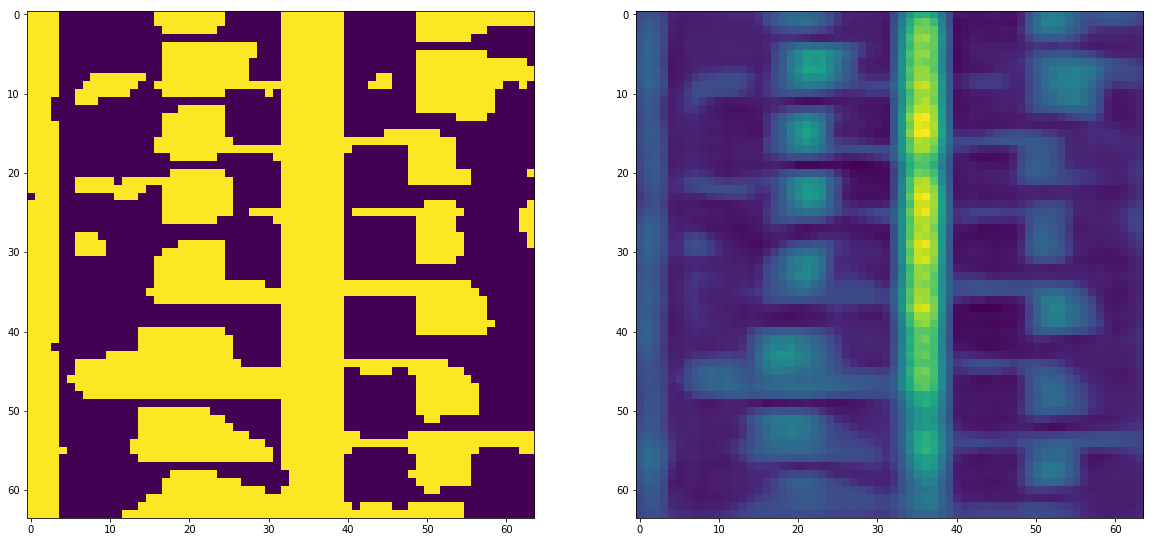

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


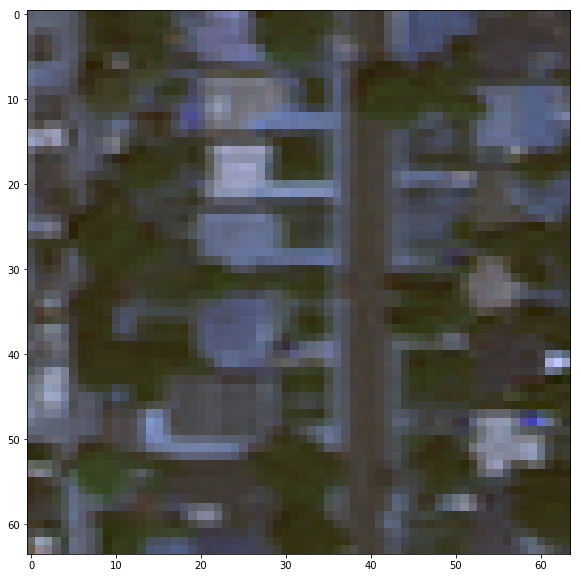

In [15]:

# check one of the test images
test_ind = 1000
input_img = torch.unsqueeze(variable(dg_dataset[test_ind], volatile=True), dim=0) 
mask = model(input_img)


mask_im = mask.squeeze().data.cpu().numpy()
mask_binary = mask_im.copy()

fig, ax = plt.subplots(1,2, figsize=(20,10))
thresh = 0
mask_binary[mask_im<=thresh] = 0
mask_binary[mask_im>thresh] = 1
ax[0].imshow(mask_binary)
# ax[0].colorbar()
gt_im = gt_dataset[test_ind].numpy().squeeze()
ax[1].imshow(mask_im)
# ax[1].colorbar()
plt.show()

plt.figure(figsize=(10,10))
source_im = dg_dataset[test_ind].numpy()
plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
plt.show()

In [23]:
img_2m.shape

(8, 2352, 3231)

In [6]:
## try to the full dataset
# input_img = torch.unsqueeze(variable(dg_dataset[test_ind], volatile=True), dim=0)



img_arr = img_2m[[1,2,4], :2048,:2048].compute()
# img_arr = img_2m[[1,2,4], :,:].compute() 
img_arr = img_transform(torch.from_numpy(img_arr))


In [7]:
input_img = torch.unsqueeze(variable(img_arr, volatile=True), dim=0)
del img_arr

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


In [8]:
model.cpu()
big_mask = model(input_img.cpu())

In [18]:
## write out with gdal
import gdal, osr

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    
rname = 'runs/debug/denver_2m_IS_UNet_BGR.tif'
aff = img_2m.affine
raster_origin = (aff.c, aff.f)
pixel_height = aff.e
pixel_width = aff.a
array2raster(rname, raster_origin, pixel_width, pixel_height, big_mask.detach().numpy().squeeze())

OSError: [Errno 12] Cannot allocate memory

In [ ]:
plt.figure(figsize=(20,20))
big_mask_arr = big_mask.detach().numpy().squeeze()
big_mask_arr_bin = big_mask_arr.copy()
big_mask_arr_bin[big_mask_arr > 0] = 1
big_mask_arr_bin[big_mask_arr <= 0] = 0
plt.imshow(big_mask_arr_bin)